In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

% matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb

In [2]:
#obsFile = 'test__pha_obs.txt'
#obsFile = 'test_single_pha.txt'
obsFile = 'astro_lsst_01_1016__pha20141031_obs.txt'
orbitFile = 'pha20141031.des'
outDir = 'astro_lsst_01_1016'

In [3]:
def setupSlicer(orbitFile, Hrange, obsFile=None):
    # Read the orbit file and set the H values for the slicer.
    slicer = slicers.MoObjSlicer()
    slicer.readOrbits(orbitFile, Hrange=Hrange)
    if obsFile is not None:
        slicer.readObs(obsFile)
    return slicer

In [4]:
npReduce = np.ma.mean
def setupMetrics(slicer, runName='opsim', metadata='', albedo=None, Hmark=None, snrLimit=None, constraint='',
                bundleNames=['Standard'], nObsPerNights=[2], nNightsPerWindows=[2], tWindows=[15]):
    # Set up the metrics.
    allBundles = {}
    basicPlotDict = {'albedo': albedo, 'Hmark': Hmark, 'npReduce': npReduce}
    summaryMetrics = [metrics.MoCompletenessMetric(),
                      metrics.MoCumulativeCompletenessMetric()]
    plotFuncs = [plots.MetricVsH(), plots.MetricVsOrbit(), plots.MetricVsOrbitPoints()]
    
  
    for md, nObsPerNight, nNightsPerWindow, tWindow in zip(bundleNames, nObsPerNights, nNightsPerWindows, tWindows):
        plotDict = {'nxbins': 200, 'nybins': 200,
                    'title': '%s: %s' % (runName, md)}
        plotDict.update(basicPlotDict)
        metric = metrics.DiscoveryMetric(nObsPerNight=nObsPerNight, tMin=0, tMax=90./60./24.,
                                         nNightsPerWindow=nNightsPerWindow, tWindow=tWindow, snrLimit=snrLimit)
        childMetrics = {'Time': metrics.Discovery_TimeMetric(metric, i=0, tStart=59580),
                        'N_Chances': metrics.Discovery_N_ChancesMetric(metric),
                        'RaDec': metrics.Discovery_RADecMetric(metric),
                        'EcLonLat': metrics.Discovery_EcLonLatMetric(metric),
                        'Velocity': metrics.Discovery_VelocityMetric(metric)}
        bundle = mmb.MoMetricBundle(metric, slicer, constraint,
                                    runName=runName, metadata=md,
                                    childMetrics=childMetrics,
                                    plotDict=plotDict, plotFuncs=plotFuncs)
        bundle.childBundles['N_Chances'].setSummaryMetrics(summaryMetrics)
        allBundles[md] = bundle
    
    return allBundles, bundleNames

In [5]:
def runMetrics(allBundles, bundleNames, outDir, resultsDb=None, Hmark=None):
    # Run metrics, write basic output in outDir.
    # Un-nest dictionaries to run all at once.
    bundleDict = {}
    count = 0
    for k, v in allBundles.iteritems():
        if isinstance(v, dict):
            for k2, v2 in v.iteritems():
                bundleDict[count] = v2
                count += 1
        else:
            bundleDict[count] = v
            count += 1
    print("Counted %d top-level metric bundles." % count)

    bg = mmb.MoMetricBundleGroup(bundleDict, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    bg.writeAll()
    bg.summaryAll()
    completenessBundles = {}
    for k in ['Completeness', 'CumulativeCompleteness']:
        completenessBundles[k] = {}
        for md in bundleNames:
            completenessBundles[k][md] = makeCompletenessBundle(allBundles[md].childBundles['N_Chances'], 
                                                                   k, Hmark=Hmark)
    return allBundles, completenessBundles

In [6]:
def makeCompletenessBundle(bundle, summaryName='CumulativeCompleteness',
                           Hmark=None, resultsDb=None):
    # Make a 'mock' metric bundle from a bundle which had the
    # MoCompleteness or MoCumulativeCompleteness summary metrics run.
    # This lets us use a normal plotHandler to generate combined plots.
    try:
        bundle.summaryValues[summaryName]
    except (TypeError, KeyError):
        if summaryName == 'Completeness':
            metric = metrics.MoCompletenessMetric()
        else:
            metric = metrics.MoCumulativeCompletenessMetric()
        bundle.setSummaryMetrics(metric)
        bundle.computeSummaryStats(resultsDb)
    completeness = ma.MaskedArray(data=bundle.summaryValues[summaryName]['value'],
                                  mask=np.zeros(len(bundle.summaryValues[summaryName]['value'])),
                                  fill_value=0)
    mb = mmb.MoMetricBundle(metrics.MoCompletenessMetric(metricName=summaryName),
                            bundle.slicer, constraint=None, metadata=bundle.metadata,
                            runName=bundle.runName)
    plotDict = {}
    plotDict.update(bundle.plotDict)
    plotDict['label'] = bundle.metadata
    mb.metricValues = completeness
    if Hmark is not None:
        metric = metrics.ValueAtHMetric(Hmark=Hmark)
        mb.setSummaryMetrics(metric)
        mb.computeSummaryStats(resultsDb)
        val = mb.summaryValues['Value At H=%.1f' % Hmark]
        if summaryName == 'Completeness':
            plotDict['label'] += ' : @ H(=%.1f) = %.1f%s' % (Hmark, val*100, '%')
        else:
            plotDict['label'] += ' : @ H(<=%.1f) = %.1f%s' % (Hmark, val*100, '%')
    mb.setPlotDict(plotDict)
    return mb

In [230]:
def flattenDiscoveryMetricResults(allBundles, bundleNames, childMetric):
    flattened = {}
    for md in bundleNames:
        flattened[md] = np.swapaxes(allBundles[md].childBundles[childMetric].metricValues, 0, 1).flatten().compressed()
    return flattened

def sliceDiscoveryMetricResults(allBundles, bundleNames, childMetric, hValue, hRange=Hrange):
    sliced = {}
    for md in bundleNames:
        sliced[md] = np.swapaxes(allBundles[md].childBundles[childMetric].metricValues, 0, 1)[np.where(hRange == hValue)[0]].compressed()
    return sliced

def plotVelocityHist(allBundles, bundleNames, slicer, width=0.05, bins=10, vRange=None, hValues=None, titleAdd=""):
    
    velocity = flattenDiscoveryMetricResults(allBundles, bundleNames, "Velocity")
    
    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(10,14)
    hist, edges = np.histogram(slicer.obs["velocity"], bins=bins, range=vRange)
    
    for i, (md, color) in enumerate(zip(bundleNames, colors)):
        md_hist, md_edges = np.histogram(velocity[md], bins=edges)
        ax[0].bar(edges[:-1] + width*(i), md_hist, width, color=color, label=md)
        ax[1].plot(edges[:-1], md_hist, c=color, label=md)
        
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel("Velocity")
    ax[0].set_ylabel("Num Detections")
    ax[0].set_title("Velocity Distribution for All H-Magnitudes%s" % " " + titleAdd)
   
    ax[1].legend(loc="upper right")
    ax[1].set_xlabel("Velocity")
    ax[1].set_ylabel("Num Detections")
    ax[1].set_title("Velocity Distribution for All H-Magnitudes%s" % " " + titleAdd)
    
    if hValues is not None:
        for hValue in hValues:
            velocity = sliceDiscoveryMetricResults(allBundles, bundleNames, "Velocity", hValue)
            
            fig, ax = plt.subplots(2,1)
            fig.set_size_inches(10,14)
            hist, edges = np.histogram(slicer.obs["velocity"], bins=bins, range=vRange)

            for i, (md, color) in enumerate(zip(bundleNames, colors)):
                md_hist, md_edges = np.histogram(velocity[md], bins=edges)
                ax[0].bar(edges[:-1] + width*(i), md_hist, width, color=color, label=md)
                ax[1].plot(edges[:-1], md_hist, c=color, label=md)

            ax[0].legend(loc="upper right")
            ax[0].set_xlabel("Velocity")
            ax[0].set_ylabel("Num Detections")
            ax[0].set_title("Velocity Distribution @ H = %s%s" % (hValue, " " + titleAdd))

            ax[1].legend(loc="upper right")
            ax[1].set_xlabel("Velocity")
            ax[1].set_ylabel("Num Detections")
            ax[1].set_title("Velocity Distribution @ H = %s%s" % (hValue, " " + titleAdd))
    
    return

def plotSolarElongationHist(allBundles, bundleNames, slicer, width=1.5, bins=18, hValues=None, titleAdd=""):
    
    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(10,14)
    hist, edges = np.histogram(slicer.obs["solarelon"], bins=bins)
    
    for i, (md, color) in enumerate(zip(bundleNames, colors)):
        lon, lat, elong = zip(*eclonlat[md])
        md_hist, md_edges = np.histogram(elong, bins=edges)
        ax[0].bar(edges[:-1] + width*(i), md_hist, width, color=color, label=md)
        ax[1].plot(edges[:-1], md_hist, c=color, label=md)
        
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel("Solar Elongation")
    ax[0].set_ylabel("Num Detections")
    ax[0].set_title("Solar Elongaton Distribution for All H-Magnitudes%s" % " " + titleAdd)
        
    ax[1].legend(loc="upper right")
    ax[1].set_xlabel("Solar Elongation Bins")
    ax[1].set_ylabel("Num Detections")
    ax[1].set_title("Solar Elongaton Distribution for All H-Magnitudes%s" % " " + titleAdd)
    
    if hValues is not None:
        for hValue in hValues:
            
            fig, ax = plt.subplots(2,1)
            fig.set_size_inches(10,14)
            hist, edges = np.histogram(slicer.obs["solarelon"], bins=bins)

            for i, (md, color) in enumerate(zip(bundleNames, colors)):
                lon, lat, elong = zip(*eclonlat[md])
                md_hist, md_edges = np.histogram(elong, bins=edges)
                ax[0].bar(edges[:-1] + width*(i), md_hist, width, color=color, label=md)
                ax[1].plot(edges[:-1], md_hist, c=color, label=md)

            ax[0].legend(loc="upper right")
            ax[0].set_xlabel("Solar Elongation")
            ax[0].set_ylabel("Num Detections")
            ax[0].set_title("Solar Elongaton Distribution @ H = %s%s" % (hValue, " " + titleAdd))

            ax[1].legend(loc="upper right")
            ax[1].set_xlabel("Solar Elongation Bins")
            ax[1].set_ylabel("Num Detections")
            ax[1].set_title("Solar Elongaton Distribution @ H = %s%s" % (hValue, " " + titleAdd))

    return

def plotRaDec(allBundles, bundleNames, slicer, hValues=None, seperateBundles=False, titleAdd=""):

    if seperateBundles:
        radec = flattenDiscoveryMetricResults(allBundles, bundleNames, "RaDec")
        
        fig, ax = plt.subplots(3,1)
        fig.set_size_inches(10,21)

        for i, (md, color) in enumerate(zip(bundleNames, colors)):
            ax[i].scatter(*zip(*radec[md]), c=color, s=5, label=md, lw=0)
            ax[i].set_ylabel("Dec")
            ax[i].set_xlabel("RA")
            ax[i].set_title("Ra Dec for All H-Magnitudes in %s%s" % (md, " " + titleAdd))
            
        if hValues is not None:
            for hValue in hValues:
                radec = sliceDiscoveryMetricResults(allBundles, bundleNames, "RaDec", hValue)
                
                fig, ax = plt.subplots(3,1)
                fig.set_size_inches(10,21)

                for i, (md, color) in enumerate(zip(bundleNames, colors)):
                    ax[i].scatter(*zip(*radec[md]), c=color, s=5, label=md, lw=0)
                    ax[i].set_ylabel("Dec")
                    ax[i].set_xlabel("RA")
                    ax[i].set_title("Ra Dec for %s @ H = %s%s" % (md, hValue, " " + titleAdd))
    
    else:
        radec = flattenDiscoveryMetricResults(allBundles, bundleNames, "RaDec")
    
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10,7)

        for md, color in zip(bundleNames[::-1], colors[::-1]):
            ax.scatter(*zip(*radec[md]), c=color, s=5, label=md, lw=0, alpha=0.5)

        ax.set_ylabel("Dec")
        ax.set_xlabel("RA")
        ax.set_title("Ra Dec for All H-Magnitudes%s" % " " + titleAdd);
        ax.legend(loc="lower left");

        if hValues is not None:
            for hValue in hValues:
                radec = sliceDiscoveryMetricResults(allBundles, bundleNames, "RaDec", hValue)

                fig, ax = plt.subplots(1,1)
                fig.set_size_inches(10,7)

                for md, color in zip(bundleNames[::-1], colors[::-1]):
                    ax.scatter(*zip(*radec[md]), c=color, s=5, label=md, lw=0, alpha=0.5)

                ax.set_ylabel("Dec")
                ax.set_xlabel("RA")
                ax.set_title("Ra Dec @ H = %s%s" % (hValue, " " + titleAdd));
                ax.legend(loc="lower left");

    return

def plotEcLonLat(allBundles, bundleNames, slicer, hValues=None, seperateBundles=False, titleAdd=""):
    
    if seperateBundles:
        eclonlat = flattenDiscoveryMetricResults(allBundles, bundleNames, "EcLonLat")
        
        fig, ax = plt.subplots(3,1)
        fig.set_size_inches(10,21)

        for i, (md, color) in enumerate(zip(bundleNames, colors)):
            lon, lat, elong = zip(*eclonlat[md])
            ax[i].scatter(lon, lat, c=color, s=5, label=md, lw=0)
            ax[i].set_ylabel("Latitude")
            ax[i].set_xlabel("Longitude")
            ax[i].set_title("Ecliptic Longitude and Latitude for All H-Magnitudes in %s%s" % (md, " " + titleAdd))
            
        if hValues is not None:
            for hValue in hValues:
                eclonlat = sliceDiscoveryMetricResults(allBundles, bundleNames, "EcLonLat", hValue)
                
                fig, ax = plt.subplots(3,1)
                fig.set_size_inches(10,21)

                for i, (md, color) in enumerate(zip(bundleNames, colors)):
                    lon, lat, elong = zip(*eclonlat[md])
                    ax[i].scatter(lon, lat, c=color, s=5, label=md, lw=0)
                    ax[i].set_ylabel("Latitude")
                    ax[i].set_xlabel("Longitude")
                    ax[i].set_title("Ecliptic Longitude and Latitude in %s @ H = %s%s" % (md, hValue, " " + titleAdd))
    
    else:

        eclonlat = flattenDiscoveryMetricResults(allBundles, bundleNames, "EcLonLat")

        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(10,7)

        for md, color in zip(bundleNames[::-1], colors[::-1]):
            lon, lat, elong = zip(*eclonlat[md])
            ax.scatter(lon, lat, c=color, s=5, label=md, lw=0, alpha=0.5)

        ax.set_ylabel("Latitude")
        ax.set_xlabel("Longitude")
        ax.set_title("Ecliptic Longitude and Latitude for All H-Magnitudes %s" % " " + titleAdd);
        ax.legend(loc="lower left");

        if hValues is not None:
            for hValue in hValues:
                eclonlat = sliceDiscoveryMetricResults(allBundles, bundleNames, "EcLonLat", hValue)

                fig, ax = plt.subplots(1,1)
                fig.set_size_inches(10,7)

                for md, color in zip(bundleNames[::-1], colors[::-1]):
                    lon, lat, elong = zip(*eclonlat[md])
                    ax.scatter(lon, lat, c=color, s=5, label=md, lw=0, alpha=0.5)

                ax.set_ylabel("Latitude")
                ax.set_xlabel("Longitude")
                ax.set_title("Ecliptic Longitude and Latitude @ H = %s%s" % (hValue, " " + titleAdd));
                ax.legend(loc="lower left");

    return

In [231]:
def plotMetrics(allBundles, bundleNames, completenessBundles, outDir, 
                metadata='', runName='opsim', Hmark=None, resultsDb=None,
                hValues=None, seperateBundles=False, vRanges=[(0.0, 2.0)],
                titleAdd=""):
    
    # Make the plots.

    colorlist = ['red', 'green', 'cyan']
    # Combine differential completeness summary values, over multiple years for discoveryChances.
    ph = plots.PlotHandler(outDir=outDir, savefig=True, resultsDb=resultsDb,
                           figformat='pdf', dpi=600, thumbnail=True)
    
    # Plot the discovery chances for the two metrics
    plotbundles = []
    for md in bundleNames:
        plotbundles.append(allBundles[md].childBundles['N_Chances'])
    ph.setMetricBundles(plotbundles)
    ph.plot(plotFunc=plots.MetricVsH())
   
    # Plot the differential completeness for the two metrics
    plotbundles = []
    for md in bundleNames:
        plotbundles.append(completenessBundles['Completeness'][md])
    ph.setMetricBundles(plotbundles)
    ph.plot(plotFunc=plots.MetricVsH())
    
    # Add custom plots
    # Plot Ra, Dec
    plotRaDec(allBundles, bundleNames, slicer, hValues=hValues, titleAdd=titleAdd)
    if seperateBundles:
        plotRaDec(allBundles, bundleNames, slicer, hValues=hValues, seperateBundles=seperateBundles, titleAdd=titleAdd)
        
    # Plot Ecliptic Lon, Lat
    plotEcLonLat(allBundles, bundleNames, slicer, hValues=hValues, titleAdd=titleAdd)
    if seperateBundles:
        plotEcLonLat(allBundles, bundleNames, slicer, hValues=hValues, seperateBundles=seperateBundles, titleAdd=titleAdd)
        
    # Plot Velocity histograms
    for vRange in vRanges:
        plotVelocityHist(allBundles, bundleNames, slicer, vRange=vRange, hValues=hValues, titleAdd=titleAdd)
        
    # Plot Solar elongation histograms
    plotSolarElongationHist(allBundles, bundleNames, slicer, titleAdd=titleAdd)

In [184]:
hMark = 22
hMin = 12
hMax = 25
hStep = 0.5
Hrange = np.arange(hMin, hMax + hStep, hStep)
slicer = setupSlicer(orbitFile, Hrange, obsFile=obsFile)

In [9]:
bundleNames = ["Single Detection", "Single Pair", "Standard"]
nObsPerNights = [1, 2, 2]
nNightsPerWindows = [1, 1, 3]
tWindows = [15, 15, 15]
snrLimit = 3
colors = ["Red", "Green", "Blue"]

In [10]:
allBundles, bundleNames = setupMetrics(slicer, 
                                       bundleNames=bundleNames,
                                       nObsPerNights=nObsPerNights,
                                       nNightsPerWindows=nNightsPerWindows,
                                       tWindows=tWindows,
                                       Hmark=hMark,
                                       snrLimit=snrLimit,
                                       runName='astro_lsst_01_1016')
allBundles, completenessBundles = runMetrics(allBundles, bundleNames, outDir)

Counted 3 top-level metric bundles.
Calculated all metrics.
Saving metric bundles.


/Users/joachim/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:1101: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->[12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0]]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


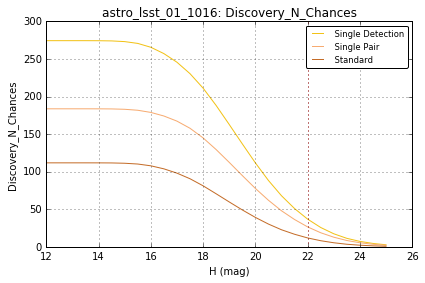

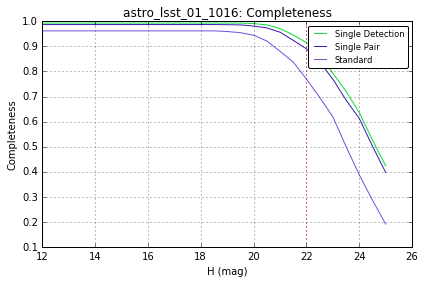

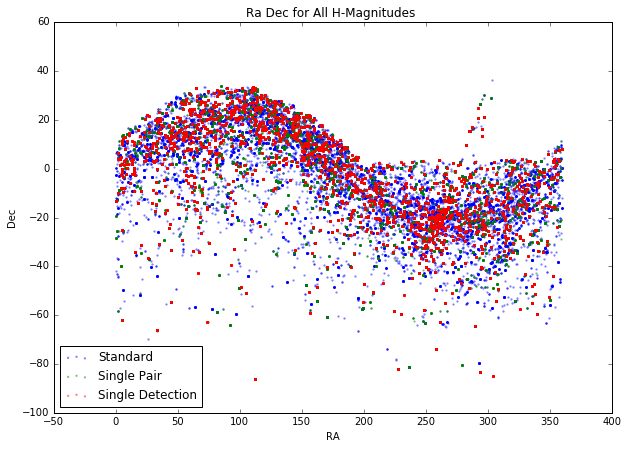

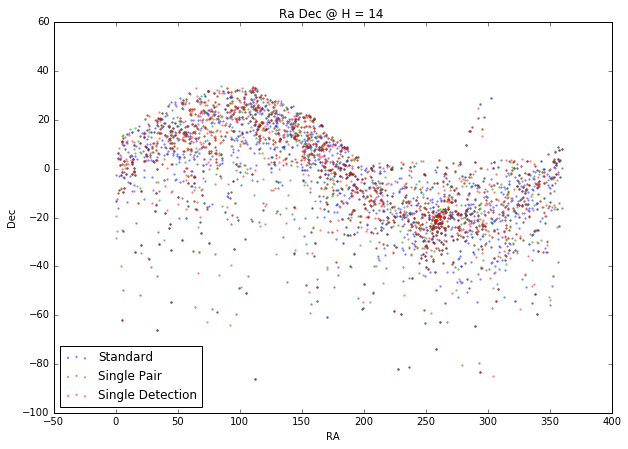

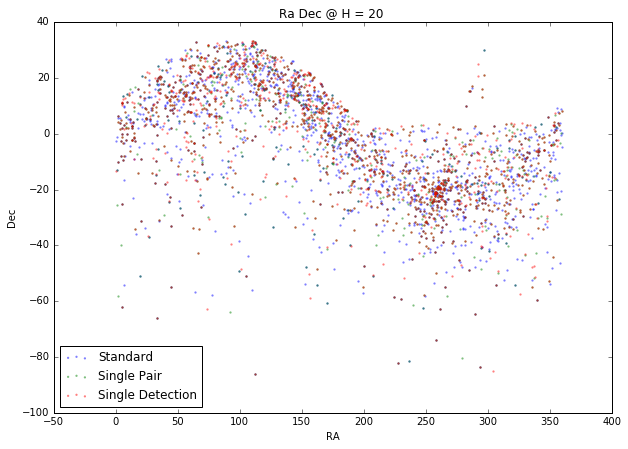

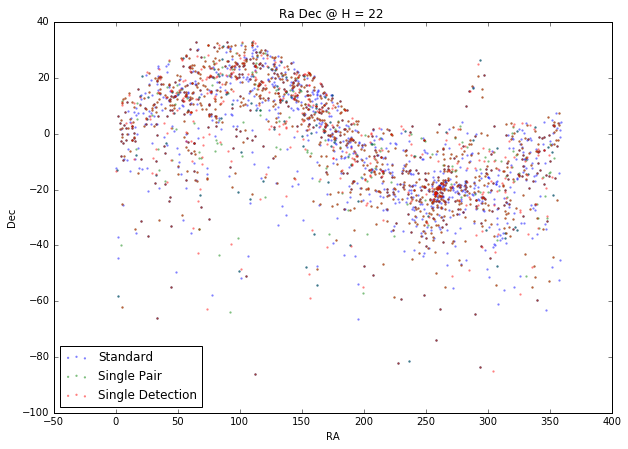

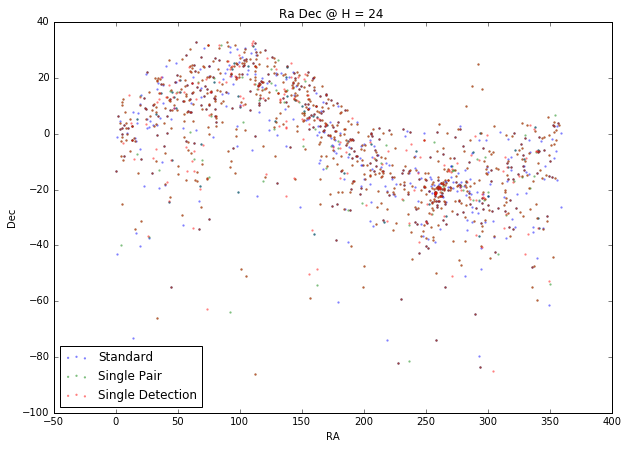

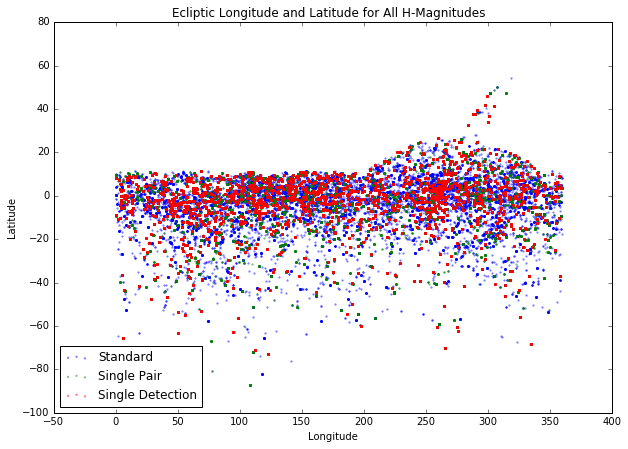

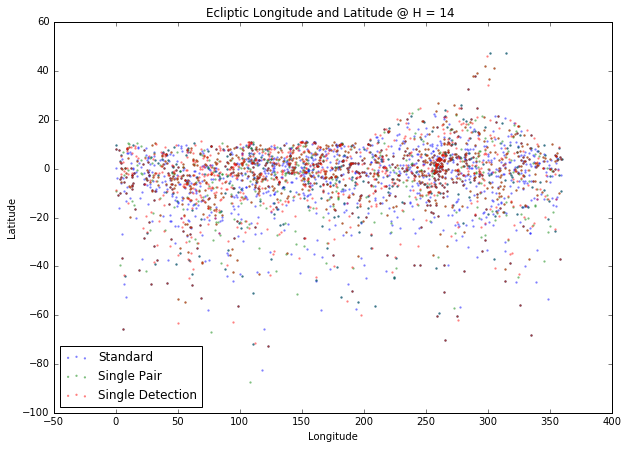

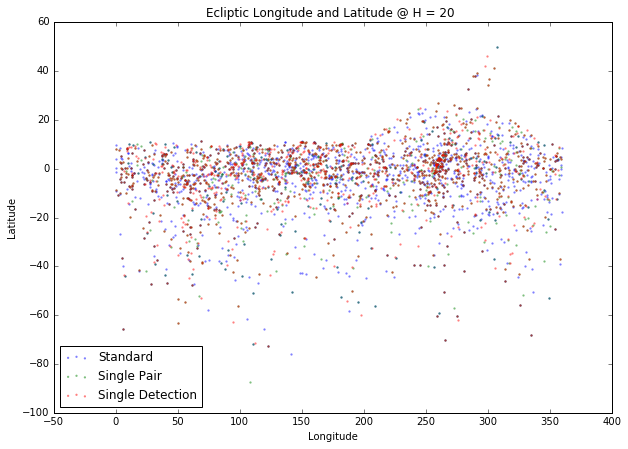

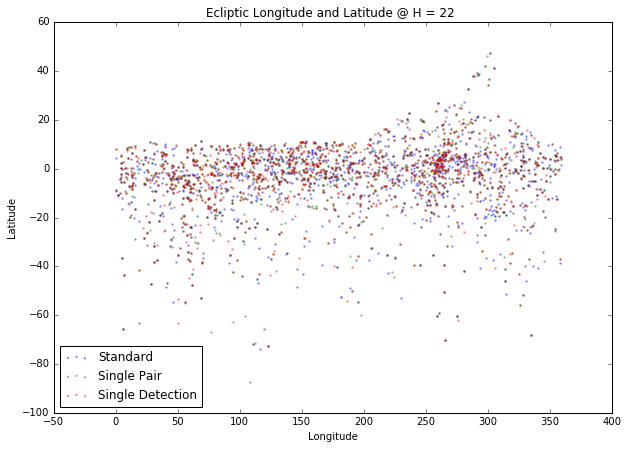

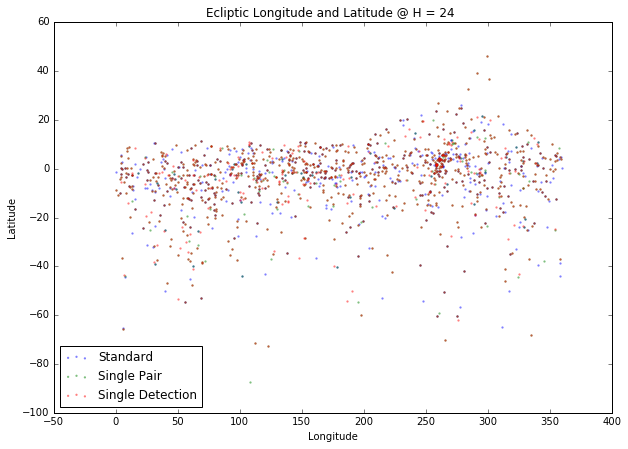

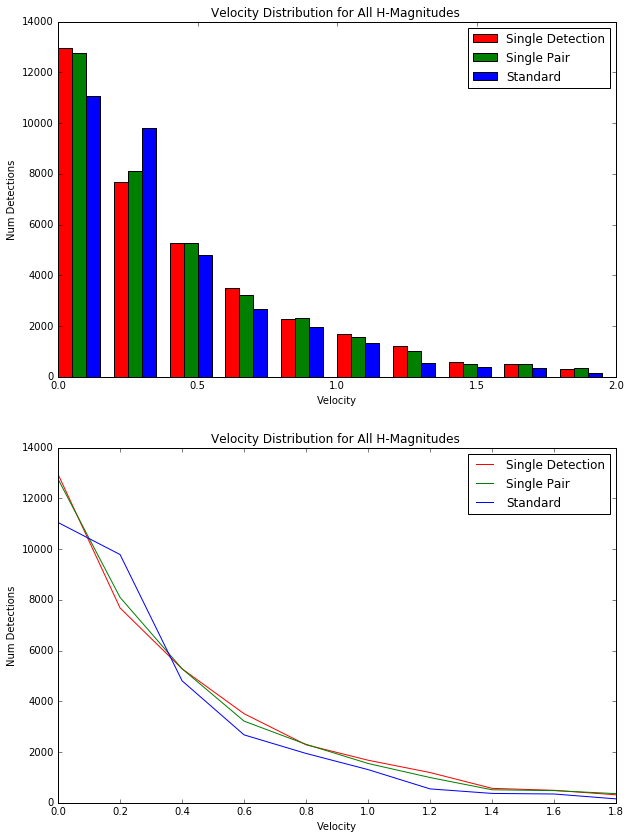

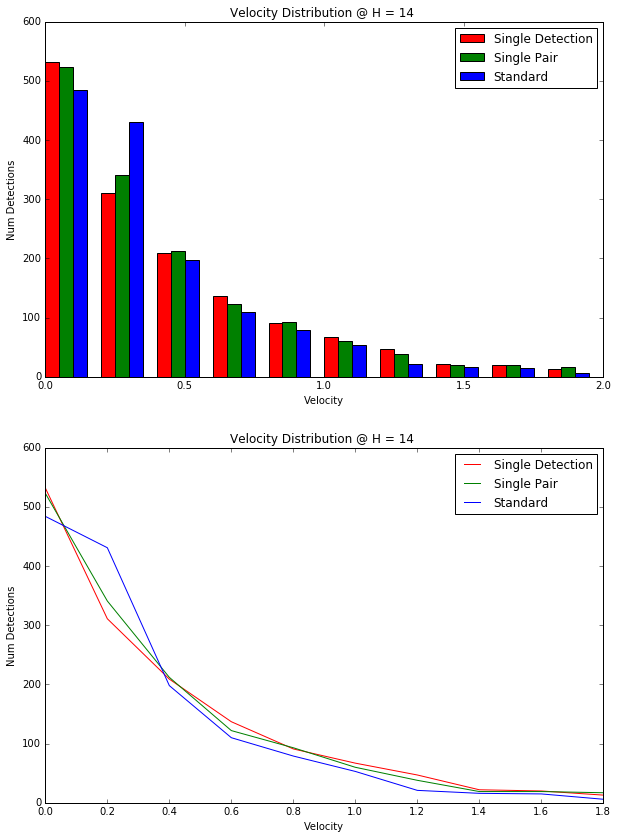

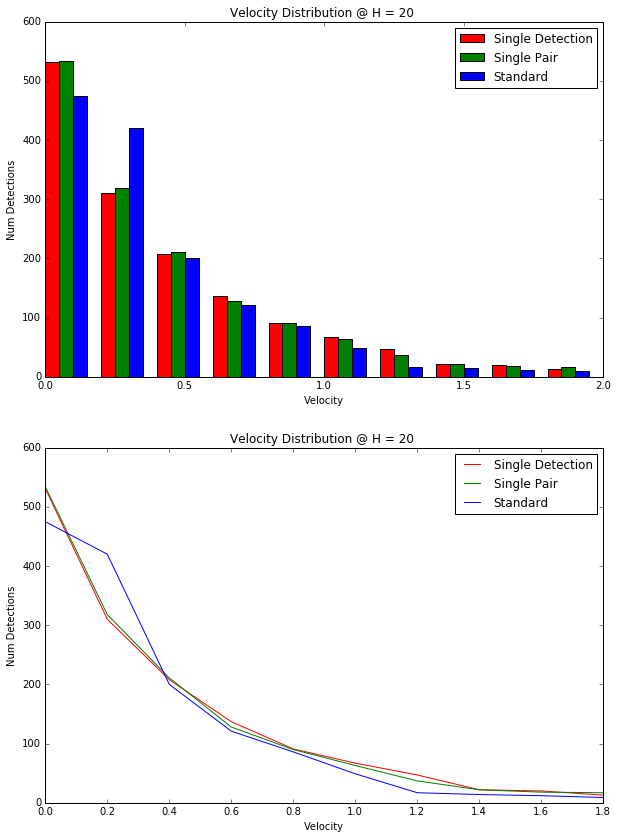

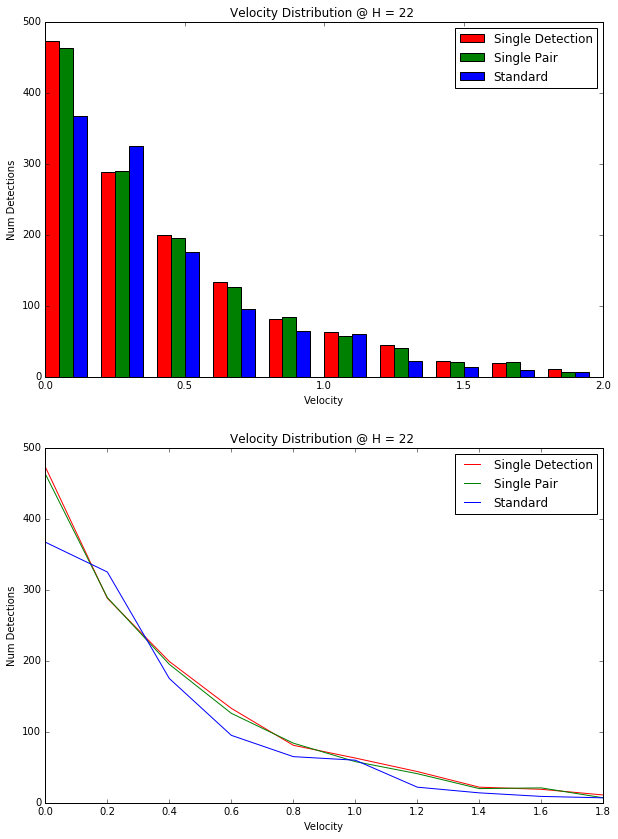

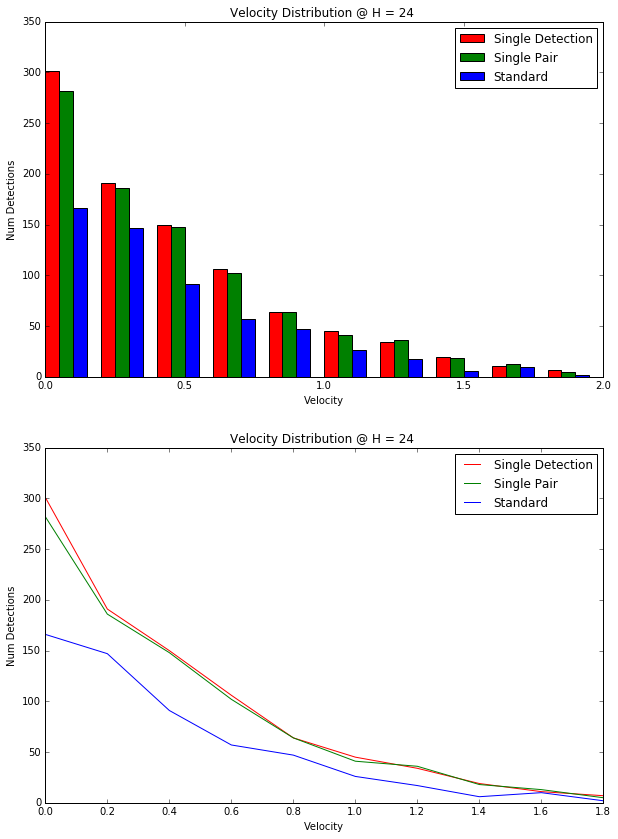

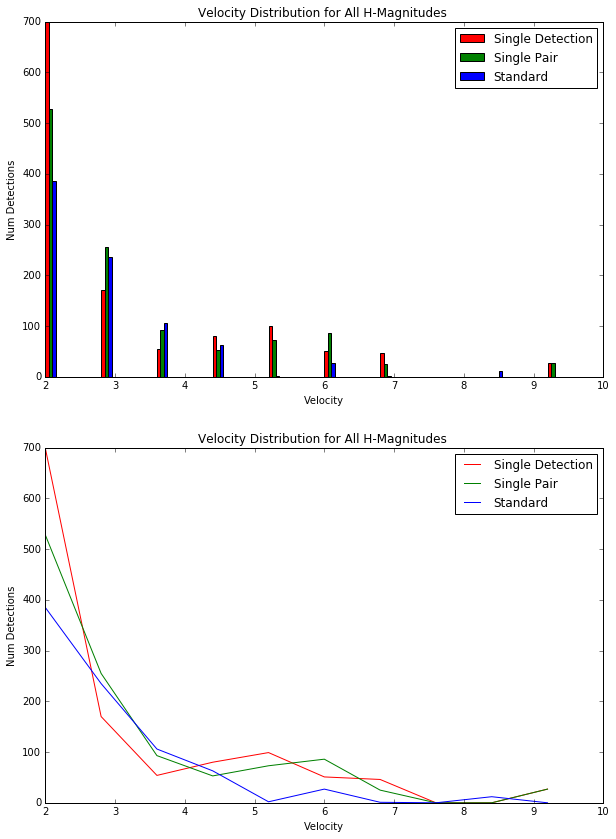

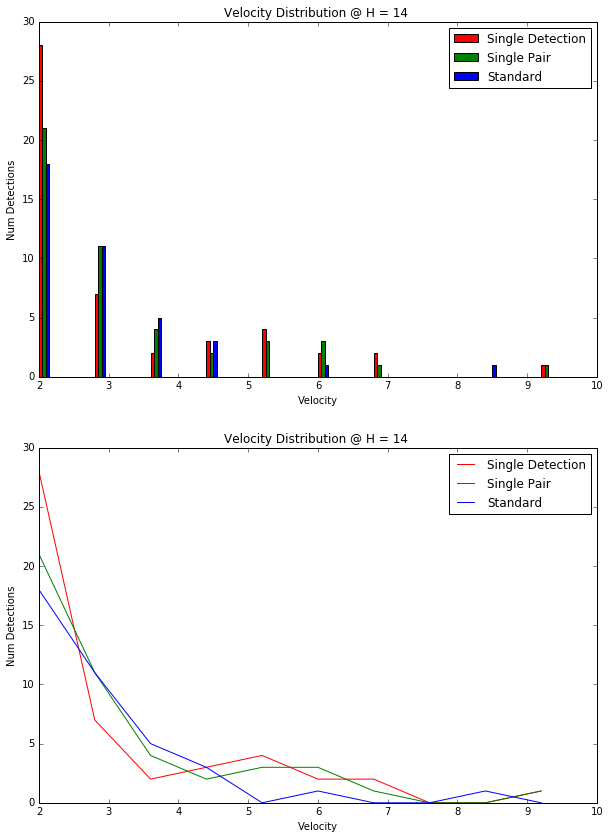

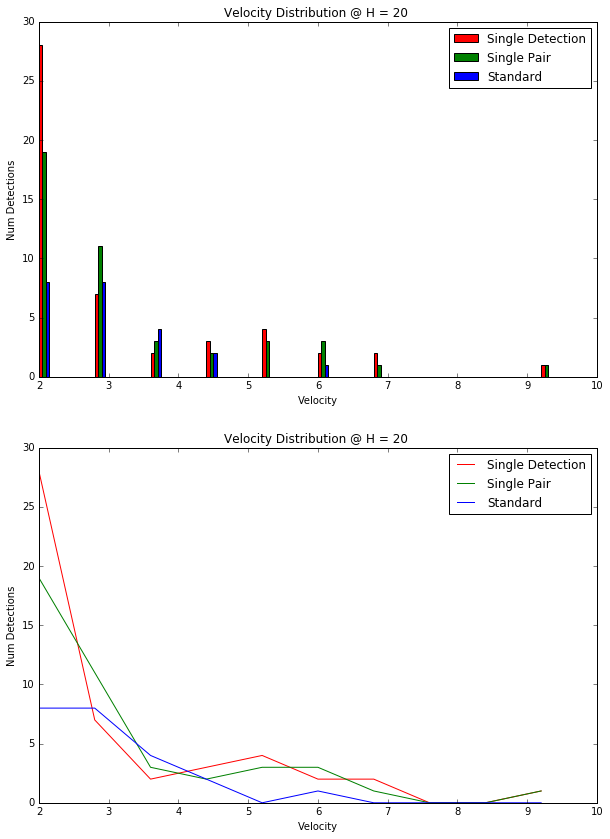

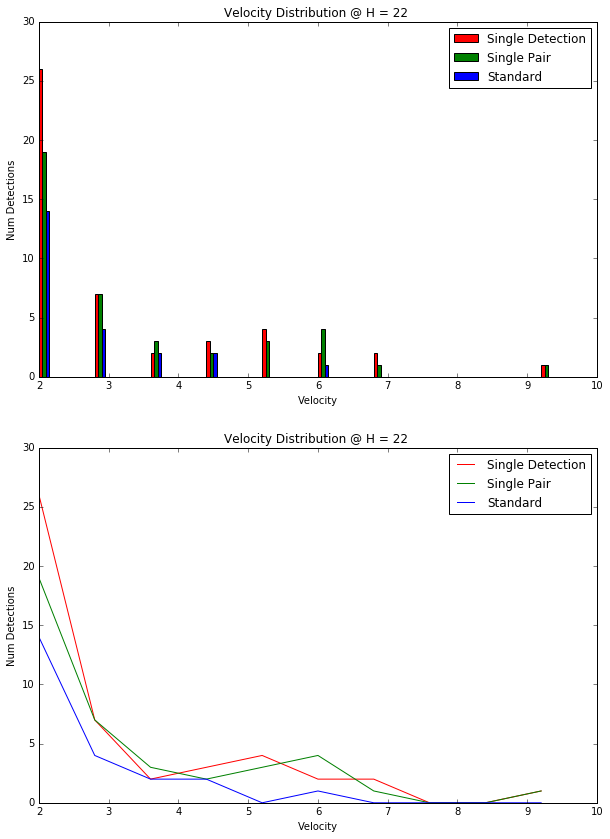

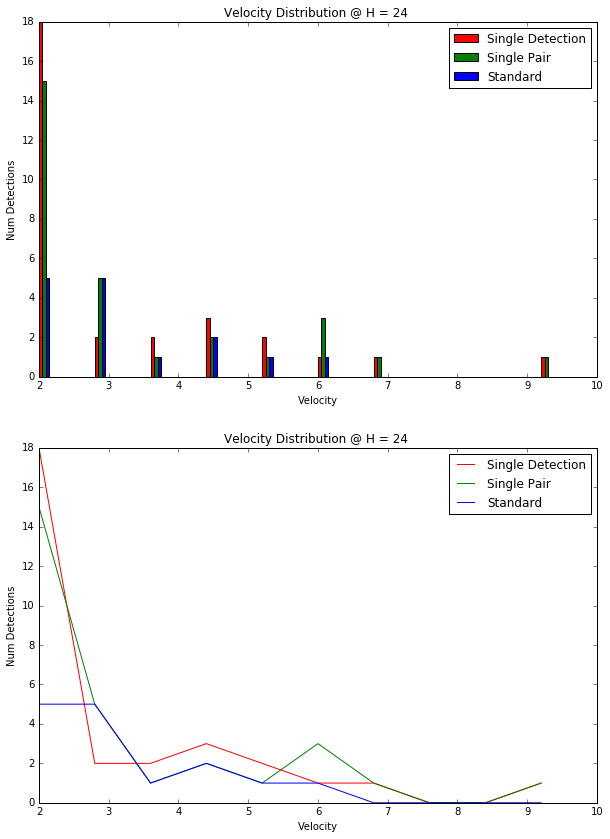

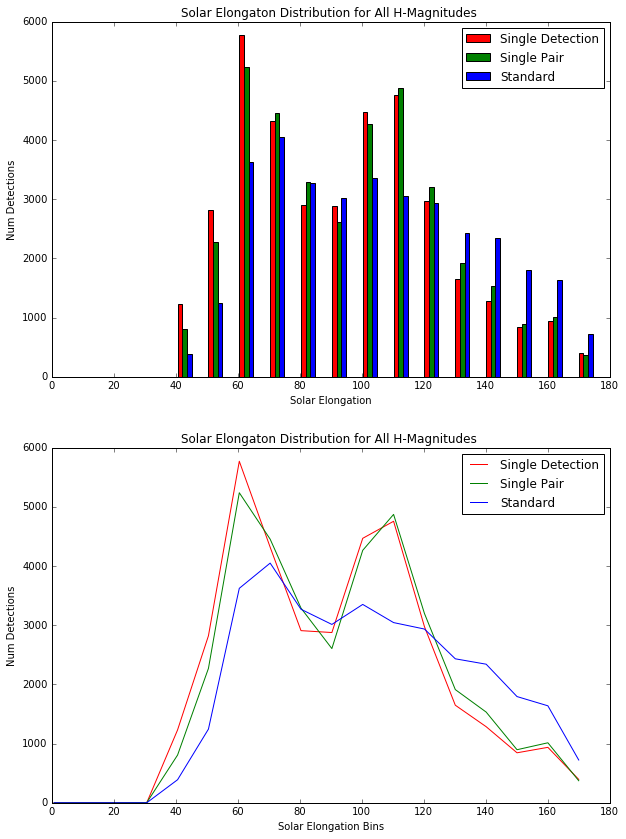

In [232]:
plotMetrics(allBundles, bundleNames, completenessBundles, outDir, hValues=[14,20,22,24], vRanges=[(0.0, 2.0), (2.0, 10.0)])

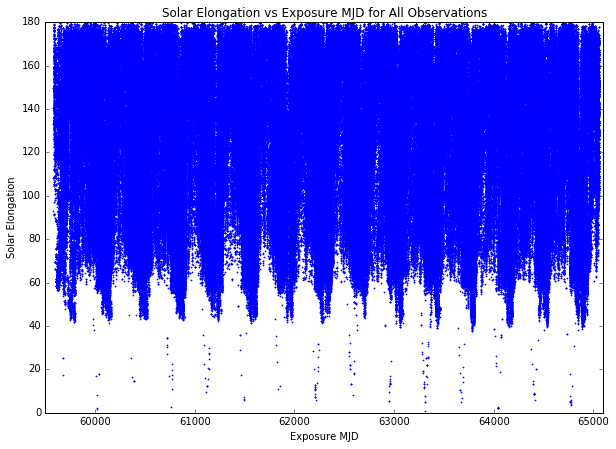

In [82]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)

ax.scatter(slicer.obs["expMJD"], slicer.obs["solarelon"], s=3, lw=0)
ax.set_title("Solar Elongation vs Exposure MJD for All Observations")
ax.set_xlabel("Exposure MJD")
ax.set_ylabel("Solar Elongation")
ax.set_ylim(0, 180);
ax.set_xlim(59500,65100);

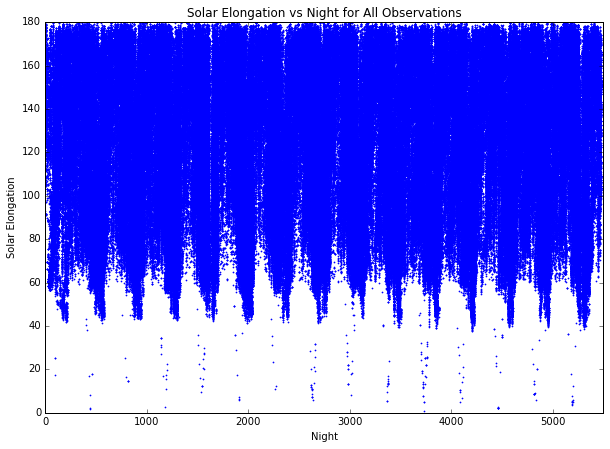

In [81]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,7)

ax.scatter(slicer.obs["night"], slicer.obs["solarelon"], s=3, lw=0)
ax.set_title("Solar Elongation vs Night for All Observations")
ax.set_xlabel("Night")
ax.set_ylabel("Solar Elongation")
ax.set_ylim(0, 180);
ax.set_xlim(0, 5500);

In [12]:
allBundles_u, bundleNames_u = setupMetrics(slicer, 
                                       bundleNames=bundleNames,
                                       nObsPerNights=nObsPerNights,
                                       nNightsPerWindows=nNightsPerWindows,
                                       tWindows=tWindows,
                                       Hmark=hMark,
                                       snrLimit=snrLimit,
                                       constraint='filter = u',
                                       runName='astro_lsst_01_1016_u')
allBundles_u, completenessBundles_u = runMetrics(allBundles, bundleNames, outDir)

allBundles_g, bundleNames_g = setupMetrics(slicer, 
                                       bundleNames=bundleNames,
                                       nObsPerNights=nObsPerNights,
                                       nNightsPerWindows=nNightsPerWindows,
                                       tWindows=tWindows,
                                       Hmark=hMark,
                                       snrLimit=snrLimit,
                                       constraint='filter = g',
                                       runName='astro_lsst_01_1016_g')
allBundles_g, completenessBundles_g = runMetrics(allBundles, bundleNames, outDir)

allBundles_r, bundleNames_r = setupMetrics(slicer, 
                                       bundleNames=bundleNames,
                                       nObsPerNights=nObsPerNights,
                                       nNightsPerWindows=nNightsPerWindows,
                                       tWindows=tWindows,
                                       Hmark=hMark,
                                       snrLimit=snrLimit,
                                       constraint='filter = r',
                                       runName='astro_lsst_01_1016_r')
allBundles_r, completenessBundles_r = runMetrics(allBundles, bundleNames, outDir)

allBundles_i, bundleNames_i = setupMetrics(slicer, 
                                       bundleNames=bundleNames,
                                       nObsPerNights=nObsPerNights,
                                       nNightsPerWindows=nNightsPerWindows,
                                       tWindows=tWindows,
                                       Hmark=hMark,
                                       snrLimit=snrLimit,
                                       constraint='filter = i',
                                       runName='astro_lsst_01_1016_i')
allBundles_i, completenessBundles_i = runMetrics(allBundles, bundleNames, outDir)

allBundles_z, bundleNames_z = setupMetrics(slicer, 
                                       bundleNames=bundleNames,
                                       nObsPerNights=nObsPerNights,
                                       nNightsPerWindows=nNightsPerWindows,
                                       tWindows=tWindows,
                                       Hmark=hMark,
                                       snrLimit=snrLimit,
                                       constraint='filter = z',
                                       runName='astro_lsst_01_1016_z')
allBundles_z, completenessBundles_z = runMetrics(allBundles, bundleNames, outDir)

allBundles_y, bundleNames_y = setupMetrics(slicer, 
                                       bundleNames=bundleNames,
                                       nObsPerNights=nObsPerNights,
                                       nNightsPerWindows=nNightsPerWindows,
                                       tWindows=tWindows,
                                       Hmark=hMark,
                                       snrLimit=snrLimit,
                                       constraint='filter = y',
                                       runName='astro_lsst_01_1016_y')
allBundles_y, completenessBundles_y = runMetrics(allBundles, bundleNames, outDir)

Counted 3 top-level metric bundles.
Calculated all metrics.
Saving metric bundles.
Counted 3 top-level metric bundles.
Calculated all metrics.
Saving metric bundles.
Counted 3 top-level metric bundles.
Calculated all metrics.
Saving metric bundles.
Counted 3 top-level metric bundles.
Calculated all metrics.
Saving metric bundles.
Counted 3 top-level metric bundles.
Calculated all metrics.
Saving metric bundles.
Counted 3 top-level metric bundles.
Calculated all metrics.
Saving metric bundles.
